# MS2 Extraction

With MS1 features of interest determined by peak detection, corresponding tandem mass spectra, if available, must be extracted and assigned to the MS1 parent ion feature. 
For data independent acquisition, we use non-*m/z* dimensions to assign fragments; for instance, drift time and retention time are used to match fragments in LC-IMS-MS/MS. 
These additional separations enable better attribution of MS2 ions to parent ions, a form of deconvolution inherent in the acquisition, but convolution artifacts can still occur. 

Explicit, algorithmic deconvolution has been implemented such that MS1 and MS2 features overlapping in non-*m/z* separation dimensions are disambiguated to minimize false assignments.
In this form of deconvolution, the profile(s) of non-*m/z* separation dimensions are used to identify only those ions in the MS2 with distributions that correspond to the precursor ion distribution.
This technique simultaneously excludes MS2 ions arising from noise or chemical background, while also attributing MS2 ions only to precursor ions with similar separation distributions.

## Drift Time Offset Correction

In these data, the mass analyzer connected to the drift tube acts in itself like a miniature ion mobility separation aparatus, wherein separations are a function of both the ion mobility drift time of the percursor ion, as well as the voltage applied in the collision cell.
As such, when an ion in the MS1 experiences a collsion energy of 0 eV, while its fragment ions experience higher collision energies (in this example, 20 eV), their reported drift times will be "offset" proportional to the collision energy difference.
That is, the MS2 ions, under higher voltage, will travel faster than the corresponding MS1 ions, and thus will have a lower reported drift time.

To demonstrate, we'll visualize the drift time dimension of a selected precursor and its putative MS2 fragments.

In [16]:
import deimos
import matplotlib.pyplot as plt

In [2]:
ms1 = deimos.load('example_data.h5', key='ms1', columns=['mz', 'drift_time', 'retention_time', 'intensity'])
ms2 = deimos.load('example_data.h5', key='ms2', columns=['mz', 'drift_time', 'retention_time', 'intensity'])

In [27]:
ms1_peaks = deimos.load('example_data_peaks.h5', key='ms1')
ms2_peaks = deimos.load('example_data_peaks.h5', key='ms2')

In [28]:
ms1_peaks

,mz,drift_time,retention_time,intensity
0,49.956387,1.923968,21.285550,53.0
1,49.956387,7.094632,3.896433,51.0
2,49.956387,13.948768,2.273700,61.0
3,49.956387,31.023984,10.040200,123.0
4,49.958832,31.865720,16.957817,67.0
...,...,...,...,...
377626,1698.493774,25.733072,14.330167,122.0
377627,1698.493774,34.511176,4.514750,75.0
377628,1698.493774,35.352912,10.697450,128.0
377629,1698.493774,37.757872,3.973633,51.0


In [21]:
# get maximal data point
mz_i, dt_i, rt_i, intensity_i = ms1.loc[ms1['intensity'] == ms1['intensity'].max(), :].values[0]

# subset the raw data
precursor = deimos.slice(ms1,
                       by=['mz', 'drift_time', 'retention_time'],
                       low=[mz_i - 0.1, dt_i - 1, rt_i - 1],
                       high=[mz_i + 0.2, dt_i + 1, rt_i + 2])

# putative fragments
fragment_profile = deimos.slice(ms2,
                                by=['drift_time', 'retention_time'],
                                low=[dt_i - 1.5, rt_i - 1],
                                high=[dt_i + 1, rt_i + 2])

In [22]:
fragment_dt = deimos.collapse(fragment_profile, keep='drift_time').sort_values(by='drift_time')
precursor_dt = deimos.collapse(precursor, keep='drift_time').sort_values(by='drift_time')

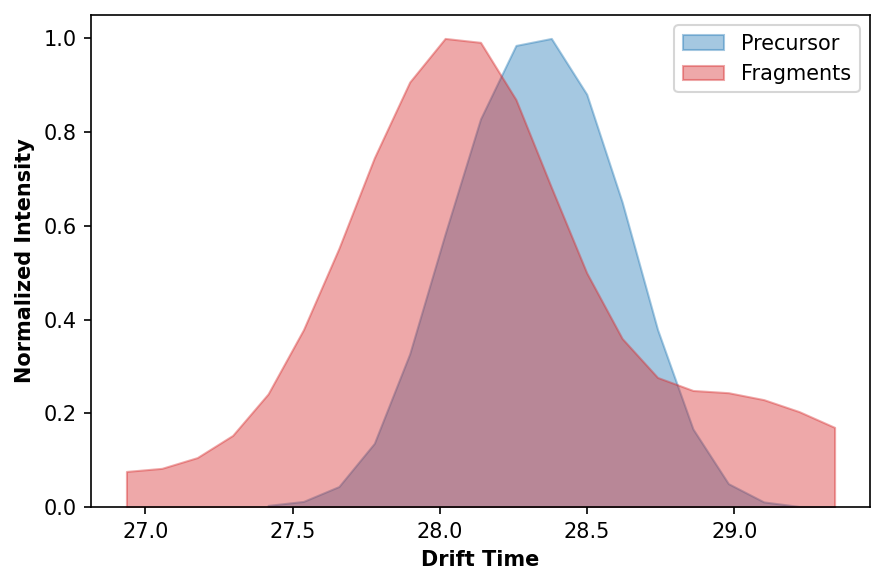

In [25]:
fig, ax = plt.subplots(1, dpi=150, facecolor='w')

ax.fill_between(precursor_dt['drift_time'],
                precursor_dt['intensity'] / precursor_dt['intensity'].max(),
                color='C0', alpha=0.4, label='Precursor')

ax.fill_between(fragment_dt['drift_time'],
                fragment_dt['intensity'] / fragment_dt['intensity'].max(),
                color='C3', alpha=0.4, label='Fragments')

ax.set_xlabel('Drift Time', fontweight='bold')
ax.set_ylabel('Normalized Intensity', fontweight='bold')
ax.set_ylim(0, None)
ax.legend()

plt.tight_layout()
plt.show()

## Deconvolution

For computational efficiency, we will only consider MS1 features of high intensity (>1E4) and MS2 features at least 1% of the MS1 intensity (>1E3).

In [4]:
ms1_peaks = deimos.threshold(ms1_peaks, threshold=1E4)
ms2_peaks = deimos.threshold(ms2_peaks, threshold=1E3)

While a convenience function for deconvolution exists, it is better to use the class implementation for understanding.
First, instantiate the `MS2Deconvolution` class.

In [5]:
decon = deimos.deconvolution.MS2Deconvolution(ms1_peaks, ms1, ms2_peaks, ms2)

Next, perform clustering of the MS1 and MS2 features to determine groupings in non-*m/z* dimensions (i.e. drift and retention time) for deconvolution.
The below will perform agglomerative clustering with a maximum linkage distance of 10% in drift time and 0.3 minutes in retention time.

In [6]:
decon.cluster(dims=['drift_time', 'retention_time'],
              tol=[0.1, 0.3],
              relative=[True, False])

,mz,drift_time,retention_time,intensity,ms_level,cluster
0,59.058609,22.606624,9.692533,10646.0,1,58
1,103.052551,12.626040,8.610767,10340.0,1,26
2,104.105240,13.227280,9.267517,32393.0,1,135
3,114.063881,13.948768,4.939783,39767.0,1,90
4,114.089745,13.828520,1.578367,11760.0,1,88
...,...,...,...,...,...,...
871,1597.187500,4.569424,1.210900,2435.0,2,24
872,1598.196899,4.689672,1.172317,1613.0,2,24
873,1618.159546,4.569424,1.210900,1277.0,2,24
874,1619.175659,4.569424,1.133717,1039.0,2,24


The per-dimension bounds to consider for each feature must be specified using the `configure_profile_extraction` method.
Keyword arguments `low` and `high` indicate the upper and lower bound of each feature per dimension, `relative` indicates whether to use relative or absolute tolerances per dimension, and `resolution` signals the sampling interval of the interpolated profile, per dimension.
No computation is performed here.

In [7]:
decon.configure_profile_extraction(dims=['mz', 'drift_time', 'retention_time'],
                                   low=[-200E-6, -0.05, -0.3],
                                   high=[600E-6, 0.05, 0.3],
                                   relative=[True, True, False],
                                   resolution=[0.01, 0.01, 0.01])

Finally, we apply the configured deconvolution routine to yield a deconvolved result, signaling which dimensions to consider for the deconvolution with the `dims` keyword argument.
Computational cost scales with the dimensionality of the data and the number of MS1 and MS2 features considered.
Partitioning, as used in the peak detection module, is not yet supported for deconvolution.

In [8]:
%%time
res = decon.apply(dims=['drift_time', 'retention_time'])

CPU times: user 15min 21s, sys: 14min 16s, total: 29min 37s
Wall time: 33min 20s


The data frame returned is in long format.
To yield the deconvolution result per MS1 feature, simply perform a `groupby` operation.

In [13]:
res.groupby(by=[x for x in res.columns if x.endswith('_ms1')], as_index=False).agg(list)

,mz_ms1,drift_time_ms1,retention_time_ms1,intensity_ms1,mz_ms2,drift_time_ms2,retention_time_ms2,intensity_ms2,drift_time_score,retention_time_score
0,59.058609,22.606624,9.692533,10646.0,"[59.05860900878906, 132.073486328125, 152.0673...","[22.606624, 22.606624, 21.404144, 22.84712]","[9.673233333333, 9.789016666667, 9.71183333333...","[13665.0, 1803.0, 1383.0, 1007.0]","[0.9912206162761006, 0.9552676603792464, 0.137...","[0.9905280167360012, 0.12704711307346706, 0.90..."
1,103.052551,12.626040,8.610767,10340.0,"[77.03711700439453, 51.02070999145508, 94.0638...","[12.505792, 12.505792, 12.265296]","[8.591466145833, 8.5527171875, 8.398333333333]","[7111.0, 3656.0, 1662.0]","[0.9622234174865092, 0.8807230528599731, 0.127...","[0.9979641698649876, 0.9726603123040728, 0.220..."
2,104.105240,13.227280,9.267517,32393.0,[60.07852554321289],[13.107032],[9.248216666667],[9316.0],[0.9294833542932688],[0.9954061139386534]
3,114.063881,13.948768,4.939783,39767.0,[114.06388092041016],[13.948768],[4.920483333333],[1464.0],[0.9822119634412789],[0.9327520917684752]
4,118.085197,13.708272,8.224500,50966.0,"[58.0632438659668, 59.071903228759766, 118.085...","[13.708272, 13.708272, 13.708272]","[8.2052, 8.2052, 8.2438]","[38688.0, 24609.0, 8984.0]","[0.8948030397111325, 0.9274368763483205, 0.996...","[0.9985287752637312, 0.9954667295797205, 0.992..."
...,...,...,...,...,...,...,...,...,...,...
74,810.597900,36.916136,1.114417,17833.0,"[59.05860900878906, 782.5677490234375, 810.597...","[35.352912, 35.833904, 36.795888, 35.954152, 3...","[1.056366666667, 1.133716666667, 1.09511666666...","[17951.0, 15896.0, 13445.0, 11084.0, 8219.0, 6...","[0.0989026206826098, 0.1274129860020401, 0.969...","[0.26047933625700426, 0.9868563309396281, 0.99..."
75,843.013794,31.625224,13.634333,14059.0,"[515.0045166015625, 433.002197265625, 597.0090...","[31.26448, 31.384728, 32.947952, 31.26448, 33....","[13.57645, 13.615033333333, 13.6538, 13.6538, ...","[9343.0, 6477.0, 2758.0, 1842.0, 1609.0, 1410....","[0.5854177064257423, 0.43312715820023096, 0.30...","[0.9950563593486041, 0.9964424291824504, 0.996..."
76,991.671997,40.162832,1.848850,20569.0,"[991.6719970703125, 992.6744995117188, 993.677...","[40.042584, 39.922336, 40.042584, 40.042584, 3...","[1.82955, 1.82955, 1.82955, 1.86815, 1.9453333...","[19481.0, 11900.0, 4883.0, 2372.0, 1313.0, 127...","[0.977093978519515, 0.9778753535627279, 0.9805...","[0.9993069556702037, 0.9994843634360785, 0.999..."
77,992.674500,40.162832,1.848850,11782.0,"[991.6719970703125, 992.6744995117188, 993.677...","[40.042584, 39.922336, 40.042584, 40.042584, 3...","[1.82955, 1.82955, 1.82955, 1.86815, 1.9453333...","[19481.0, 11900.0, 4883.0, 2372.0, 1313.0, 127...","[0.9737675404241237, 0.9743986905994639, 0.977...","[0.9992516788147279, 0.9992185010644623, 0.999..."


In the above command, however, no deconvolution information has yet been leveraged.
To do so, we must filter by the columns `drift_time_score` and `retention_time_score` to keep only those fragment profiles with high agreement with the MS1 precursor.
Selection here depends on the quality of the offset correction.

In [14]:
res.loc[(res['drift_time_score'] > 0.9)
        & (res['retention_time_score'] > 0.9)].groupby(by=[x for x in res.columns if x.endswith('_ms1')], as_index=False).agg(list)

,mz_ms1,drift_time_ms1,retention_time_ms1,intensity_ms1,mz_ms2,drift_time_ms2,retention_time_ms2,intensity_ms2,drift_time_score,retention_time_score
0,59.058609,22.606624,9.692533,10646.0,[59.05860900878906],[22.606624],[9.673233333333],[13665.0],[0.9912206162761006],[0.9905280167360012]
1,103.052551,12.626040,8.610767,10340.0,[77.03711700439453],[12.505792],[8.591466145833],[7111.0],[0.9622234174865092],[0.9979641698649876]
2,104.105240,13.227280,9.267517,32393.0,[60.07852554321289],[13.107032],[9.248216666667],[9316.0],[0.9294833542932688],[0.9954061139386534]
3,114.063881,13.948768,4.939783,39767.0,[114.06388092041016],[13.948768],[4.920483333333],[1464.0],[0.9822119634412789],[0.9327520917684752]
4,118.085197,13.708272,8.224500,50966.0,"[59.071903228759766, 118.08519744873047]","[13.708272, 13.708272]","[8.2052, 8.2438]","[24609.0, 8984.0]","[0.9274368763483205, 0.9963093450084843]","[0.9954667295797205, 0.9929202425544645]"
5,120.078377,14.550008,8.572167,34603.0,"[103.05255126953125, 77.03711700439453, 91.051...","[14.550008, 14.42976, 14.42976, 14.550008, 14....","[8.591466145833, 8.591466145833, 8.59146614583...","[17623.0, 16718.0, 4971.0, 2771.0, 1259.0]","[0.9663323098661412, 0.9021139674470906, 0.936...","[0.9985517539039431, 0.9975840866501811, 0.995..."
6,132.073486,14.429760,9.885833,30613.0,[90.05123901367188],[14.42976],[9.905133333333],[1443.0],[0.9635818243390735],[0.9524685994203652]
7,137.045166,14.550008,5.751067,35949.0,"[137.045166015625, 110.03237915039062, 119.034...","[14.550008, 14.550008, 14.550008, 14.550008, 1...","[5.770366666667, 5.809116666667, 5.77036666666...","[12003.0, 11294.0, 10817.0, 6459.0, 4095.0, 13...","[0.9939715498132347, 0.963396517832718, 0.9725...","[0.9959390643691627, 0.9921641651049448, 0.992..."
8,138.051331,14.309512,8.610767,36471.0,"[92.04826354980469, 94.06383514404297, 138.051...","[14.189264, 14.189264, 14.309512, 14.069016, 1...","[8.630233854167, 8.591466145833, 8.63023385416...","[16007.0, 12855.0, 11421.0, 2839.0, 2780.0, 16...","[0.9351622643690555, 0.9541944991358869, 0.992...","[0.9950203926899273, 0.9979616376892639, 0.993..."
9,144.099182,14.670256,7.258183,53635.0,"[144.09918212890625, 84.07734680175781, 145.10...","[14.670256, 14.550008, 14.670256, 14.670256, 1...","[7.1617, 7.238883333333, 7.04575, 7.2003, 7.27...","[33113.0, 20702.0, 4782.0, 4437.0, 2128.0, 142...","[0.9900466927561545, 0.9215611216166015, 0.987...","[0.9752936631577761, 0.9945162926187932, 0.932..."


Now that the inner workings of the deconvolution heuristic are understood, the convenience function `deconvolve_ms2` may be invoked as follows to produce the same result.

In [ ]:
res = deimos.deconvolution.deconvolve_ms2(ms1_peaks, ms1, ms2_peaks, ms2,
                                          cluster_kwargs={'dims': ['drift_time', 'retention_time'],
                                                          'tol': [0.1, 0.3],
                                                          'relative': [True, False]},
                                          profile_kwargs={'dims': ['mz', 'drift_time', 'retention_time'],
                                                          'low': [-200E-6, -0.05, -0.3],
                                                          'high': [600E-6, 0.05, 0.3],
                                                          'relative': [True, True, False],
                                                          'resolution': [0.01, 0.01, 0.01]},
                                          apply_kwargs={'dims': ['drift_time', 'retention_time']})